<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP4/ML_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina, TP N° 4: Fake News

In [ ]:
import pandas as pd

true_news_df = pd.read_csv("https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/3_MidtermProjects/ProjectFN/data/true.csv")
fake_news_df = pd.read_csv("https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/3_MidtermProjects/ProjectFN/data/fake.csv")

In [ ]:
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Agrego a cada dataframe una columna con el atributo `veracity` (`true` o `fake`), y los combino



In [ ]:
true_news_df['veracity'] = 'true'
fake_news_df['veracity'] = 'fake'
true_news_df['veracity'] = pd.Categorical(true_news_df.veracity)
fake_news_df['veracity'] = pd.Categorical(fake_news_df.veracity)

news_df = pd.concat([true_news_df, fake_news_df], ignore_index=True)
news_df

,title,text,subject,date,veracity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",fake
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",fake
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",fake
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",fake


Comparo la cantidad de artículos `fake` y `true`

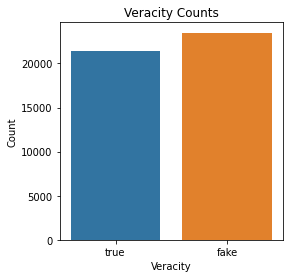

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(x="veracity", data=news_df)
ax.set_title("Veracity Counts")
ax.set_xlabel("Veracity")
ax.set_ylabel("Count")
plt.show()

Vemos que los datos están desbalanceados, por lo tanto eliminamos filas al azar de la categoría "fake" para trabajar con la misma cantidad de datos en ambos datasets, de esto se encarga la biblioteca `imblearn`

In [ ]:
# !pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X = news_df
y = news_df['veracity']
X_resampled, _ = rus.fit_resample(X, y)

news_df = pd.DataFrame(data=X_resampled, columns=news_df.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


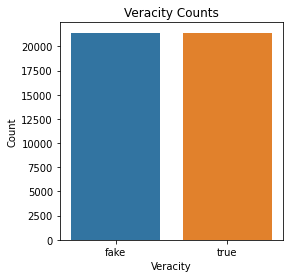

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(x="veracity", data=news_df)
ax.set_title("Veracity Counts")
ax.set_xlabel("Veracity")
ax.set_ylabel("Count")
plt.show()

Divido el dataset en entrenamiento/testeo

In [ ]:
from sklearn.model_selection import train_test_split

data = news_df.drop('veracity', axis=1)
labels = news_df['veracity']
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=1)

Voy a usar el modelo "bolsa de palabras", en el cual no se tiene en cuenta la ubicación relativa de las palabras o la gramática, sino sólo el número de veces que cada palabra aparece en los documentos.

Para esto, voy a usar tf-idf (term frequency–inverse document frequency) para evaluar el peso relativo de cada palabra en los artículos falsos y los reales. 

El método tf-idf tiene en cuenta la ocurrencia de cada palabra en cada documento dividida por la longitud del documento, obteniendo la frecuencia relativa de cada palabra. 

Además, asigna un peso a cada palabra que es inversamente proporcional a la ocurrencia de dicha palabra entre todos los documentos. Esto hace que las palabras más informativas (las menos comunes) tengan un peso mayor.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# Con stop_words='english' elimino las palabras más comunes en el idioma inglés,
# como 'the', 'and', etc

idf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm='l2')
X = idf_vectorizer.fit_transform(true_news_df.text)
X_sum=X.sum(axis=0)
true_idf = pd.DataFrame(X_sum/X_sum.max(), columns=idf_vectorizer.get_feature_names())
true_idf = true_idf.T
true_idf = true_idf.sort_values(by=0,ascending=False)
true_idf.reset_index(level=0, inplace=True)
true_idf.columns = ['word', 'weight']
print('Palabras más informativas de las noticias reales:')
true_idf.head(10)

Palabras más informativas de las noticias reales:


,word,weight
0,said,1.000000
1,trump,0.903117
2,president,0.448800
3,house,0.377567
4,state,0.365267
5,reuters,0.349891
6,republican,0.335482
7,government,0.327143
8,united,0.311150
9,states,0.308572


In [ ]:

idf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm='l2')
X = idf_vectorizer.fit_transform(fake_news_df.text)
X_sum=X.sum(axis=0)

fake_idf = pd.DataFrame(X_sum/X_sum.max(), columns=idf_vectorizer.get_feature_names())
fake_idf = fake_idf.T
fake_idf = fake_idf.sort_values(by=0,ascending=False)
fake_idf.reset_index(level=0, inplace=True)
fake_idf.columns = ['word', 'weight']
print('Palabras más informativas entre las fake news:')
fake_idf.head(10)

Palabras más informativas entre las fake news:


,word,weight
0,trump,1.000000
1,said,0.371374
2,president,0.366910
3,clinton,0.347849
4,obama,0.323422
5,people,0.320805
6,hillary,0.288202
7,donald,0.270163
8,just,0.254323
9,like,0.235270


* Comparando ambas listas, se ve que "trump" es mencionado en mayor medida en las fake news. Por otro lado el término "said" ("dijo" en castellano) se menciona mucho más en las noticias reales, lo que puede indicar un mayor uso de citas o referencias a declaraciones en las noticias reales que en las falsas.

Entreno el clasificador SVM utilizando el atributo `text` del dataset

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import numpy as np
'''
* Con ngram_range = (1,n) genero un vocabulario no sólo de las palabras
individuales sino también de conjuntos de n palabras, aunque con 
ngram_range = (1,n) (una sola palabra) obtengo el mejor resultado

* El clasificador SGDClassifier con el parámetro loss='hinge' es igual
a un SVM, pero más adecuado para trabajar con matrices dispersas:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
'''
text_clf = Pipeline([
    ('tfidf_vect', TfidfVectorizer(ngram_range=(1,1))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          random_state=42, alpha=1e-3,
                          max_iter=5, tol=None))
])

text_clf.fit(X_train.text, y_train)
y_pred = text_clf.predict(X_test.text)

Evalúo el modelo

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.98      0.97      0.97      4282
        true       0.97      0.98      0.97      4285

    accuracy                           0.97      8567
   macro avg       0.97      0.97      0.97      8567
weighted avg       0.97      0.97      0.97      8567



In [ ]:
# !pip install tabletext
from tabletext import to_text

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
C = conf_matrix / conf_matrix.astype(np.float).sum(axis=0)
conf_matrix = [['TP: %0.2f%%'%C[0,0], 'FN: %0.2f%%'%C[1,0]],
               ['FP: %0.2f%%'%C[0,1], 'TN: %0.2f%%'%C[1,1]]]

print(to_text(conf_matrix))

┌───────────┬───────────┐
│ TP: 0.98% │ FN: 0.02% │
├───────────┼───────────┤
│ FP: 0.03% │ TN: 0.97% │
└───────────┴───────────┘


Como se ve, las métricas utilizando el atributo `text` son muy buenas, voy a probar ahora utilizando sólo los títulos

In [ ]:
text_clf = Pipeline([
    ('tfidf_vect', TfidfVectorizer(ngram_range=(1,1))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          random_state=42, alpha=1e-3,
                          max_iter=5, tol=None))
])

text_clf.fit(X_train.title, y_train)
y_pred = text_clf.predict(X_test.title)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.96      0.86      0.91      4282
        true       0.88      0.97      0.92      4285

    accuracy                           0.91      8567
   macro avg       0.92      0.91      0.91      8567
weighted avg       0.92      0.91      0.91      8567



In [ ]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
C = conf_matrix / conf_matrix.astype(np.float).sum(axis=0)
conf_matrix = [['TP: %0.2f%%'%C[0,0], 'FN: %0.2f%%'%C[1,0]],
               ['FP: %0.2f%%'%C[0,1], 'TN: %0.2f%%'%C[1,1]]]

print(to_text(conf_matrix))

┌───────────┬───────────┐
│ TP: 0.96% │ FN: 0.04% │
├───────────┼───────────┤
│ FP: 0.12% │ TN: 0.88% │
└───────────┴───────────┘


Analizando sólo los títulos la precisión del modelo sigue siendo muy buena, con la ventaja de que es mucho más económico en cuanto a tiempo de entrenamiento